# pytRIBS

## The Need For pytRIBS
pytRIBS was designed to aid users of the TIN-based Real-time Integrated Basin Simulator ([tRIBS](https://tribshms.readthedocs.io/en/latest/)) distributed hydrologic model in model setup, execution, and result analysis. Prior to pytRIBS, setting up a tRIBS model could take multiple days, involved a number of proprietary software programs, and was prone to user error. pytRIBS addresses all of these challenges, letting users approach hydrologic modeling in a programmatic and efficient manner.

![tRIBS Workflow](../smf_assets/tRIBS_workflow_horz.png)

**Figure 1.** A tRIBS workflow consists of three main steps: (1) Collate and generate model inputs. (2) Run the model simulation(s). (3) Review and analyze results. The first and last step (denoted by red text and dashed lines) are user intensive activities that challenge reproducibility and are often very time consuming. The asterisks denote steps required for the parallel operation of the model. 

## pytRIBS Design

!['pytRIBS Design'](../smf_assets/pytRIBS_design.png)

**Figure 2.** pytRIBS uses an object-oriented approach to capture the major components and steps required for setting up, simulating, and analyzing a tRIBS model. The preprocessing classes are intended to expedite the first step in setting up a tRIBS model, whereas the simulation classes provide users with tools to effectively run and analyze the model through a Python interface. The Project class is not directly linked to another class as it is limited to storing directory information and meta data. Only select attributes or methods are shown for each class, for a full list of attributes and methods see the associated documentation. 
*Water balance can be calculated for both the basin averaged condition or at individual nodes. 
**Mesh class relies on Preprocess and MeshGenerator classes accessed via these instances.

# Newman Canyon Full Example
The following section documents how pytRIBS can efficiently generate a locally refined TIN mesh for the TIN-based real-time integrated basin simulator (tRIBS). Here we use the Newman Canyon watershed located near Flagstaff, Arizona, USA as an example. Newman Canyon is ~60 km$^2$ with an average elevation of 2230 m.

## Imports

In [34]:
# note you can install pytRIBS via pip; see: https://pypi.org/project/pytRIBS/
from pytRIBS.classes import *

In [35]:
# if you have installed pytRIBS, the following libraries should already be in your environment
import os, sys, shutil
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from shapely.ops import unary_union
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

## Project Class: Setup Model Information

In [36]:
name ='SMF'
epsg = 26912
proj = Project(os.getcwd(),name,epsg) # Create an instance of a Project Class

The output below is the folder directory structure that pytRIBS generates where the tRIBS model data is stored.

In [37]:
proj.directories

{'model': 'data/model',
 'preprocessing': 'data/preprocessing',
 'results': 'results',
 'soil': 'data/model/soil',
 'land': 'data/model/land',
 'met_precip': 'data/model/met/precip',
 'met_meteor': 'data/model/met/meteor',
 'mesh': 'data/model/mesh'}

In [38]:
proj.meta

{'Name': 'SMF', 'Scenario': None, 'EPSG': 26912}

The code below code copies in the needed pre-processed data sets and sets file paths to required data.

In [39]:
# Set the file path to our DEM
dem = '../smf_init_data/USGS_10m_clip.tif'

# Copy over our pre-generated Soil and Land Use ID rasters into our project directories
landuse_ras = '../smf_init_data/LandUse.asc'
shutil.copy(landuse_ras, proj.directories['land'])
landuse_ras = f"{proj.directories['land']}/{os.path.basename(landuse_ras)}"

soil_ras = '../smf_init_data/ADOT_SoilTypes.asc'
shutil.copy(soil_ras, proj.directories['soil'])
soil_ras = f"{proj.directories['soil']}/{os.path.basename(soil_ras)}"

## Mesh Class: Process DEM and Generate Mesh

### Preprocessing
Here initiate the class with arguments for the Preprocessing and MeshGeneration component classes. 

Before we make a mesh we need to delineate the watershed and to do that we use the code below to define some of information required.

In [40]:
# Preprocessing Arguments
verbose_mode=False# suppresses whitebox output

# UTM coordinates for outlet/pour point
x = 394456
y = 3686772

snap_dis = 100 # allowable distance in m for snapping outlet points to stream network

# This area threshold for determining streams for watershed delineation
# Lets initially try 0.1sqkm, this value is important because it determines the number of streams in tRIBS mesh
threshold_area = 2e4 # area in m^2 for determining stream network

# tuple of preprocessing arguments to be passed into the the mesh class
preprocess_args = ([x,y],snap_dis, threshold_area, dem, verbose_mode,proj.meta,proj.directories['preprocessing'])

In [41]:
# Mesh Generation Arguments
# output directory can be specified in Preproceesing, but if not provided preprocessing is the default directory 
output_dir = proj.directories['preprocessing'] 

path_to_raster = f'{output_dir}/{name}_clipped_ext.tif' # these are default outputs but can be further modified. See documentation.
path_to_watershed = f'{output_dir}/{name}_boundary.shp'
path_to_stream_network = f'{output_dir}/{name}_stream.shp'
path_to_outlet = f'{output_dir}/{name}_outlet.shp'
maxlevel= 8 # This can be set to none, if so the maximum level possible will be used. 

mesh_generation_args = (path_to_raster, path_to_watershed, path_to_stream_network, path_to_outlet, maxlevel)

The code below executes the watershed delineation and saves all of the results to the filepaths listed above.

In [42]:
tmesh = Mesh(preprocess_args=preprocess_args, generate_mesh_args=mesh_generation_args,meta=proj.meta)

Now, we have created all the files necessary for generating a mesh. Below we provide a visualization of these data. Note you could read this data in independently then plot it, but they are all ready assigned to ```tmesh.mesh_generator``` or alternatively can be used from the MeshGeneration class.

#### Example Figure 1: Preprocessing products produced by pytRIBS

Plotting with elevation limits: 396.1m to 732.2m


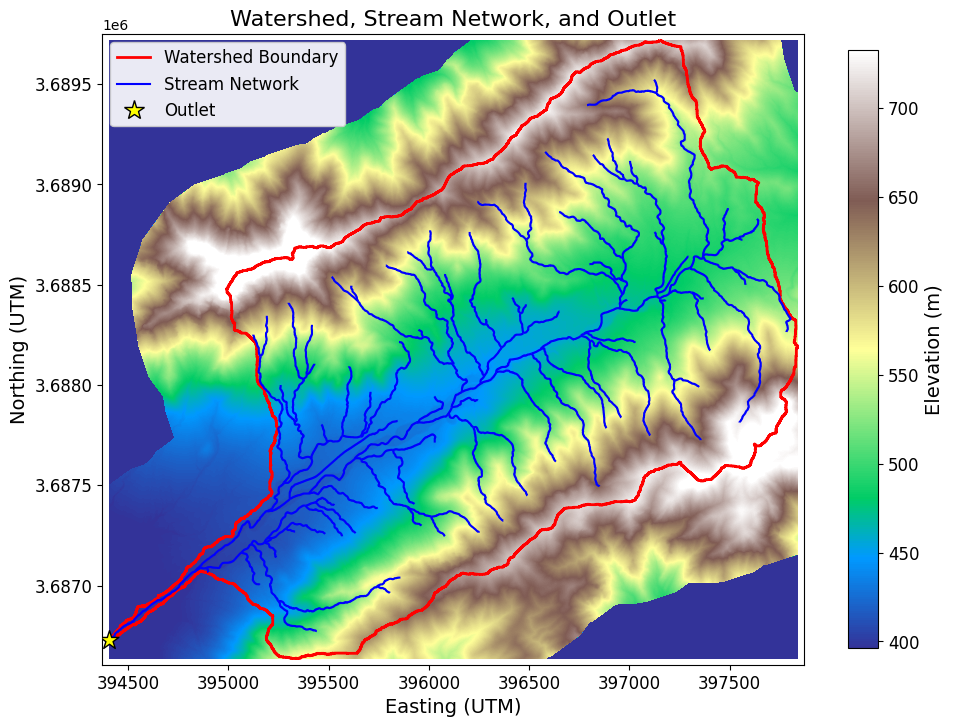

In [43]:
dem_data = tmesh.mesh_generator.data
valid_data = dem_data[dem_data > -500] 
vmin, vmax = np.percentile(valid_data, [2, 98])
print(f"Plotting with elevation limits: {vmin:.1f}m to {vmax:.1f}m")

# Create the Plot
fig, ax = plt.subplots(figsize=(10, 8))

extent = tmesh.mesh_generator.get_extent()

# Display the image with manual limits (vmin/vmax)
img = ax.imshow(
    dem_data,
    extent=extent,
    cmap='terrain',
    vmin=vmin,
    vmax=vmax 
)

# Add colorbar
cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=0.8)
cbar.set_label('Elevation (m)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Plot watershed boundary (using Geopandas .plot)
tmesh.mesh_generator.watershed.plot(
    ax=ax,
    facecolor='none',
    edgecolor='red',
    linewidth=2,
    zorder=2 # draws on top of raster
)

# Plot stream network
tmesh.mesh_generator.stream_network.plot(
    ax=ax,
    linewidth=1.5,
    color='blue', # Rivers are usually blue!
    zorder=2
)

# Plot outlet
tmesh.mesh_generator.outlet.plot(
    ax=ax,
    color='yellow',
    marker='*',
    markersize=200, # Made it a bit bigger to see
    edgecolor='black',
    zorder=3
)

# Set axis labels and title
ax.set_xlabel('Easting (UTM)', fontsize=14)
ax.set_ylabel('Northing (UTM)', fontsize=14)
ax.set_title('Watershed, Stream Network, and Outlet', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

# Create manual legend
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Watershed Boundary'),
    Line2D([0], [0], color='blue', lw=1.5, label='Stream Network'),
    Line2D([0], [0], color='yellow', marker='*', markeredgecolor='black', 
           markersize=15, linestyle='None', label='Outlet')
]

ax.legend(handles=legend_elements, loc='upper left', fontsize=12, framealpha=0.9)

# Add a buffer to zoom out slightly 
# Get the bounding box coordinates of the watershed vector
minx, miny, maxx, maxy = tmesh.mesh_generator.watershed.total_bounds

# Calculate the width and height of the watershed
width = maxx - minx
height = maxy - miny

# Define a buffer percentage (e.g., 10% on each side)
buffer_pct = 0.01

# Apply the new limits with the buffer
ax.set_xlim(minx - (width * buffer_pct), maxx + (width * buffer_pct))
ax.set_ylim(miny - (height * buffer_pct), maxy + (height * buffer_pct))

plt.tight_layout()
plt.show()

### Mesh Generation
With the data from previous steps we can generate a locally refined mesh rapidly and easily using a Harr wavelet transform. Below is an example for creating the create the points file required for a tRIBS model simulation.

While we include the example below we will be using a pre-generated mesh that is already provided with this project.

In [44]:
# This parameter is the most important piece of the mesh generation in pytRIBS.
# It controls how many points will be classified as significant thus kept versus in-significant points that don't need to be included in the mesh.
# Lower values means more points kept (denser mesh). General range from 0 to 1.
threshold = 0.5

In [45]:
# note we'll use buffered watershed for other workflows to ensure data exists outside of the mesh
points, buffered_watershed = tmesh.mesh_generator.extract_points_from_significant_details(threshold)

In [46]:
buffered_watershed = buffered_watershed.buffer(250*2)

In [47]:
# save out the buffered watershed in case you need it later
gdf = gpd.GeoDataFrame({'id':[1]}, geometry=[buffered_watershed], crs=tmesh.meta['EPSG'])
gdf.to_file(f"{proj.directories['preprocessing']}/{name}_buffered_watershed.shp")

In [48]:
# Write out points the step above to a point file that tRIBS can read.
tmesh.pointfilename['value'] = proj.directories['mesh']+'/'+name+'.points'
gdf = tmesh.mesh_generator.convert_points_to_gdf(points)
tmesh.mesh_generator.write_point_file(gdf,tmesh.pointfilename['value'])

## Soil Class: Obtain and Generate tRIBS Soil Parameters

There are two methods to provide tRIBS soil parameters: a soil ID map and table or gridded parameter rasters. For SMF since we have the ADOT soil data as polygons we will use the simpler method, a soil ID map with a lookup table. Note pytRIBS has functanility to download gridded soil datasets that are publicly available but not used in this exercise.

In [49]:
soil = Soil(meta=proj.meta)

Another component of the soil class is the initial ground water table and depth to bedrock.

Bedrock data can be quite difficult to find but it is becoming more available from Digital Soil Mapping (DSM) products. For this model we will apply the [SOLUS](https://www.nrcs.usda.gov/resources/data-and-reports/soil-landscapes-of-the-united-states-solus) dataset which has already been pre-processed for use here. Due to the shallow soils here and the dry conditions we are assuming that the initial groundwater table is essentially at the bedrock. To do that we multiplied our depth to bedrock raster by 95% i.e. if the deptht o berock is 1m then the initla groundwater depth is 0.05m above the bedrock.

All we need to do is copy over the data into our model directory.

In [50]:
# Depth to Bedrock
shutil.copy('../smf_init_data/SOLUS_Bedrock_m.asc', proj.directories['soil'])
soil.bedrockfile['value'] = f"{proj.directories['soil']}/SOLUS_Bedrock_m.asc"

# Initial Groundwater Table
shutil.copy('../smf_init_data/InitGW_95pct_mm.asc', proj.directories['soil'])
soil.gwaterfile['value'] = f"{proj.directories['soil']}/InitGW_95pct_mm.asc"

Now that the soil class is created we can tell pytRIBS that we alreayd have the soil data.

In [51]:
# Give file path of soil ID map we already copied into our directory structure at the start
soil.soilmapname['value'] = soil_ras

# We already have a blank soil data table so we just need to copy it over and link it to the soil class in pytRIBS
soil_table = '../smf_init_data/soils.sdt'
shutil.copy(soil_table, proj.directories['soil'])
soil.soiltablename['value'] = f"{proj.directories['soil']}/soils.sdt"

In [52]:
soil_table = soil.read_soil_table(textures=True)
soil_map = InOut.read_ascii(soil.soilmapname['value'])

After we have read in the soil table, we can see the associated class ID and texture as follows.

In [53]:
# Lets printout the class IDs to see what they are. They are set to the MUSYM IDs from the ADOT dataset.
for cls in soil_table:
    print(f"Class ID and texture: {cls['ID']}, {cls['Texture']}")

Class ID and texture: 1, RS
Class ID and texture: 2, CO
Class ID and texture: 3, CeD
Class ID and texture: 4, EbD
Class ID and texture: 5, Cb


In [54]:
# Lets define the soil parameters. Some are parameters are specific to each soil class, some will be static across all classes
# More information here: https://tribshms.readthedocs.io/en/latest/man/Model_Parameters_Forcings.html

# Define Hydraulic Parameters for Specific Soil Classes
# Here we map the specific soil IDs found in the ADOT dataset (MUSYM) to physical hydraulic parameters.
# In a research setting, these might be derived from pedotransfer functions (like Rosetta) or field tests.
# For this exercise, we are using the values from the ADOT data as a starting point.

# Parameters:
# - Ks: Saturated hydraulic conductivity (mm/hr)
    # This is an important calibration parameter
# - thetaS: Saturation soil moisture content (porosity) (-)
# - thetaR: Residual soil moisture content (-)
# - m: Pore size distribution index (Lambda) (-)
# - PsiB: Air entry/Bubbling pressure (mm)
# - f: Conductivity decay parameter (1/mm) - Controls how fast Ksat decreases with depth
    # This is an important calibration parameter
# - n: Porosity (-)

# Define a dictionary to map your ADOT Soil IDs to parameters.
soil_param_lookup = {
    # Soil: RS
    '1': {
        'Ks': 3.6,      # From ADOT dataset, KEY calibration parameter
        'thetaS': 0.40,  # From ADOT dataset
        'thetaR': 0.06,  # Initial guess we are using 0.5*wilting point
        'm': 0.38,       # Value selected from Rawls et al 1984.
        'PsiB': -390,    # From ADOT dataset
        'f': 0.02,       # Assume initial value, KEY calibraiton parameter
        'n': 0.40        # Initial guess we are using this is equal to thetaS
    },
    # Soil: CO
    '2': {'Ks': 2.8,  'thetaS': 0.40, 'thetaR': 0.05, 'm': 0.25, 'PsiB': -401, 'f': 0.002, 'n': 0.40},
    # Soil: CeD
    '3': {'Ks': 6.6,  'thetaS': 0.40, 'thetaR': 0.05, 'm': 0.25, 'PsiB': -183, 'f': 0.002, 'n': 0.40},
    # Soil: EbD
    '4': {'Ks': 1.0,  'thetaS': 0.42, 'thetaR': 0.10, 'm': 0.20, 'PsiB': -450, 'f': 0.002, 'n': 0.42},
    # Soil: Cb
    '5': {'Ks': 17.3, 'thetaS': 0.39, 'thetaR': 0.03, 'm': 0.18, 'PsiB': -117, 'f': 0.001, 'n': 0.39},
}

# Iterate through the soil table and assign values based on the ID lookup
# We also set the constant thermal/anisotropy parameters here.

for cls in soil_table:
    # Constant Parameters (Same for all soils in this exercise)
    cls['As'] = 1       # unsaturated zone anisotropy ratio
    cls['Au'] = 1       # saturated zone anisotropy ratio
    cls['ks'] = 0.7     # volumetric heat conductivity, J/msK
    cls['Cs'] = 1.4e6   # soil heat capacity, J/m^3k
    
    # --- Spatially Varying Hydraulic Parameters ---
    # Get the ID from the current row (ensure it's a string to match our dict keys)
    current_id = str(cls['ID'])
    
    if current_id in soil_param_lookup:
        params = soil_param_lookup[current_id]
        
        # Assign values to the pytRIBS object
        cls['Ks'] = params['Ks']
        cls['thetaS'] = params['thetaS']
        cls['thetaR'] = params['thetaR']
        cls['m'] = params['m']
        cls['PsiB'] = params['PsiB']
        cls['f'] = params['f']
        cls['n'] = params['n']
        
        print(f"Assigned parameters for Soil ID {current_id} ({cls['Texture']})")
        
    else:
        # Fallback in case something goes wrong
        print(f"WARNING: Soil ID {current_id} not found in lookup dictionary! Using defaults.")
        cls['Ks'] = 10.0
        cls['thetaS'] = 0.4
        cls['thetaR'] = 0.05
        cls['m'] = 0.2
        cls['PsiB'] = -200
        cls['f'] = 0.001
        cls['n'] = 0.001

# Write the fully populated table back to disk so tRIBS can read it
soil.write_soil_table(soil_table,soil.soiltablename['value'],textures=True)
print(f"Soil table successfully written to: {soil.soiltablename['value']}")

Assigned parameters for Soil ID 1 (RS)
Assigned parameters for Soil ID 2 (CO)
Assigned parameters for Soil ID 3 (CeD)
Assigned parameters for Soil ID 4 (EbD)
Assigned parameters for Soil ID 5 (Cb)
Soil table successfully written to: data/model/soil/soils.sdt


Now that we have the soil table lets tell tRIBS that in input file we will be using option 0 that corresponds to using the soil table not gridded parameter rasters

In [55]:
soil.optsoiltype['value'] = 0

#### Example Figure 3: Example soil classification map generated from pytRIBS Soil Class

Found 5 unique soil classes: [1 2 3 4 5]


/var/folders/9d/vv87560907s7whnvx_ss7trh0000gr/T/ipykernel_46496/3984361346.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cividis', num_classes)


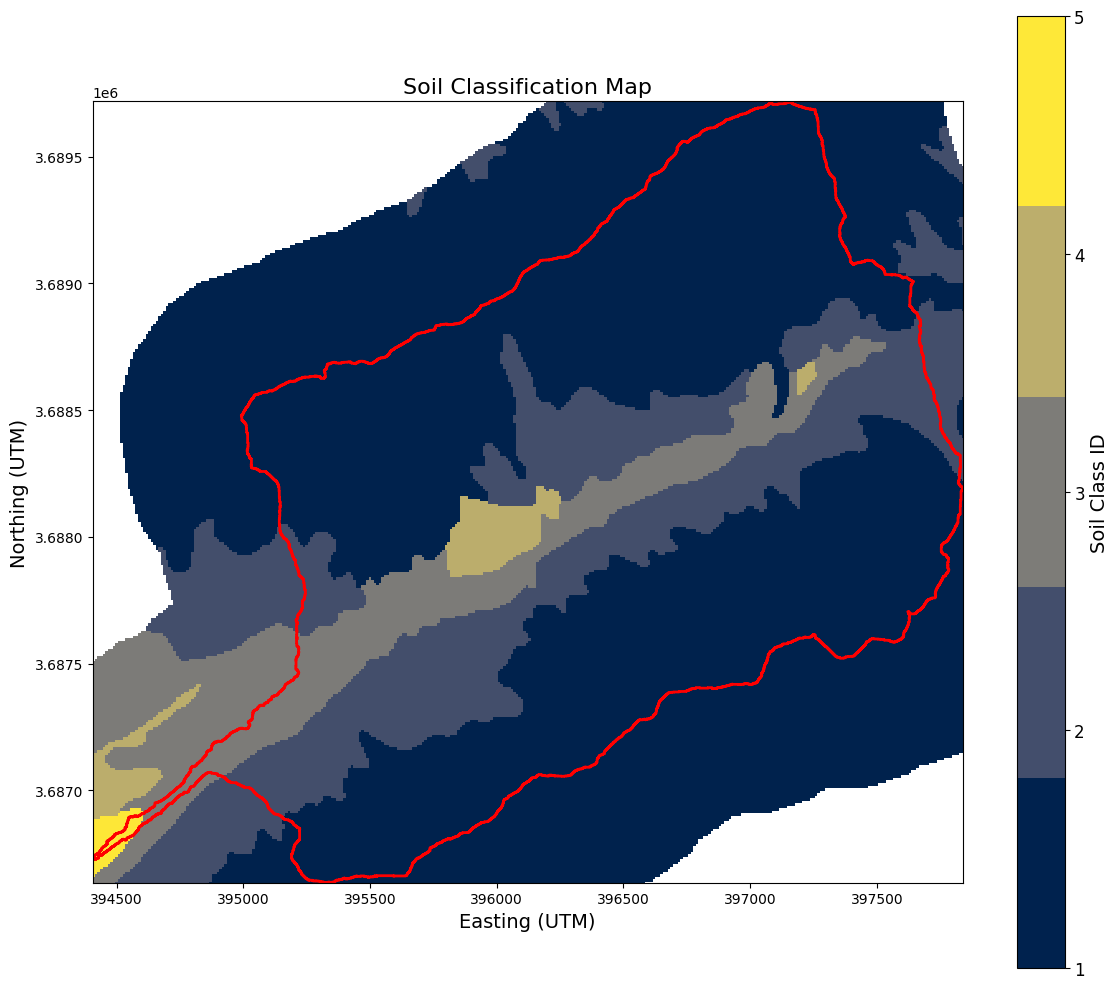

In [56]:
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import numpy as np

data = soil_map['data']
transform = soil_map['profile']['transform']

# Calculate Extent (Standard GeoTransform logic)
x_min = transform[2]
x_max = x_min + soil_map['profile']['width'] * transform[0]
y_max = transform[5]
y_min = y_max + soil_map['profile']['height'] * transform[4] 
extent = [x_min, x_max, y_min, y_max]

# Mask  Data
masked_data = np.ma.masked_less(data, 0)

# Find unique soil classes for the legend
unique_classes = np.unique(masked_data.compressed())
num_classes = len(unique_classes)

print(f"Found {num_classes} unique soil classes: {unique_classes}")

# Create Discrete Colormap
cmap = plt.cm.get_cmap('cividis', num_classes)
norm = colors.BoundaryNorm(np.arange(len(unique_classes) + 1), cmap.N) 

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))
img = ax.imshow(
    masked_data,
    extent=extent,
    cmap=cmap,
    interpolation='nearest' # Prevents blurring between classes
)

# 6. Watershed Boundary
tmesh.mesh_generator.watershed.plot(
    ax=ax, 
    facecolor='none', 
    edgecolor='red', 
    linewidth=2,
    label='Watershed Boundary'
)

# 7. Custom Colorbar for Categorical Data
# We tell the colorbar to only show ticks at the center of each discrete color
cbar = plt.colorbar(img, ax=ax, ticks=unique_classes)
cbar.set_label('Soil Class ID', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Set the limits of the image to the watershed bounds
bounds = tmesh.mesh_generator.watershed.total_bounds
ax.set_xlim([bounds[0], bounds[2]])
ax.set_ylim([bounds[1], bounds[3]])

# Labels
ax.set_xlabel('Easting (UTM)', fontsize=14)
ax.set_ylabel('Northing (UTM)', fontsize=14)
ax.set_title(f'Soil Classification Map', fontsize=16)

plt.tight_layout()
plt.show()


## Met Class:
Meteorological forcing for the tRIBS model can be supplied either as point-based station data or as raster data. Managing these data manually can be time-consuming and susceptible to errors. To simplify this process, the Met class allows users to specify the filepaths to alreayd generated forcings files or efficiently obtain meteorological forcing data from the North American Land Data Assimilation System for a specified location and time period. 

For this notebook forcing data has already been prepared so we will not be using the NLDAS workflow. First we need to tell pytRIBS the files paths where our pre-processed forcing will be located:

In [57]:
met = Met(meta=proj.meta) # Initializing the pytRIBS Met Class
met.hydrometbasename['value'] = name
met.hydrometstations['value'] = "../smf_init_data/met/Master_Met.sdf" # File path to where station data file will live
met.gaugestations['value'] = "../smf_init_data/met/Master_Precip.sdf" # File path to where station data file will live
#met.hydrometstations['value'] = f"{proj.directories['met_meteor']}/Station_Met.sdf" # File path to where station data file will live
#met.gaugestations['value'] = f"{proj.directories['met_meteor']}/Station_Precip.sdf" # File path to where station data file will live

Meteorological forcings for SMF have already been generated using the `Generate_Met_Forcing` notebook.

If you are interested in changing the simulation length or time period of the simulation you can rerun 
that notebook but it is recommended to run this notebook first entirely through to generate the main input file.
With the input file you can directly edit the main input file with the file paths to the new forcing data.

More details on the required tRIBS forcing files are located here: [Model Forcings](https://tribshms.readthedocs.io/en/latest/man/Model_Parameters_Forcings.html#model-forcings)

## Land Class: Create Land Cover Map and Assign tRIBS Land Cover Parameters
tRIBS supports spatially varying land cover parameters, which can be provided through a classification map and table, raster data, or a combination of both. These inputs may remain static over time or vary across different periods (e.g., monthly, seasonally, annually). The Land class offers various attributes and methods to manage these parameters, although the availability and resolution of land cover data often differ significantly between applications, necessitating more user input. Consequently, the Land class does not offer an all-encompassing workflow but instead provides a set of tools to manage data from various sources and helper functions to generate the necessary input files for a tRIBS simulation. 

For this notebook we have already pre-procssed the National Land Cover Database dataset (NLCD) from 2014 for the watershed. Which we already copied into the land folder at the start of this notebook. The map is broken down into `3` classes:  
`1 - South Facing Slopes`  
`2 - North Facing Slopes`  
`3 - Roadway`

While the NLCD only has the `2` land cover classes (shrub/scrub and the roadway) the shrub/scrub class was further separated into 2 classes becuase of what was observed during field visits to the site.

We will setting initial vegetation parameter based on based tRIBs project. More details on the required tRIBS parameters is located here: [Model Parameters](https://tribshms.readthedocs.io/en/latest/man/Model_Parameters_Forcings.html#model-parameters)

In [58]:
# Initialize the pytRIBS Land class
land = Land(meta=proj.meta)

In [59]:
# Tell pytRIBS where the landcover map that we already copied over exists
land.landmapname['value'] = f"{proj.directories['land']}/LandUse.asc"
land.landtablename['value'] = f"{proj.directories['land']}/land_use_params.ldt"

In [60]:
# Similar to how we set up the Soil Table we will make a dictionary of parameter values then use the pytRIBS writing function

# Define the Land Use Parameter Dictionary
land_param_lookup = {
    # Class 1: South Facing Slopes (e.g., Scrub/Shrub)
    '1': {
        'P': 0.4,       # Sparse canopy, lots of throughfall
        'S': 1.5,       # Low storage
        'K': 0.12,      # Drainage Coeff
        'b2': 4.7,      # Drainage Exp
        'Al': 0.18,     # Lower albedo (darker)
        'h': 1,       # Short vegetation
        'Kt': 0.4,      # Optical transmission
        'Rs': 120,      # High resistance (desert plants)
        'V': 0.15,       # Vegetation Fraction (40% bare soil)
        'LAI': 1.5,     # Low Leaf Area Index
        'theta*_s': 0.37, # Soil Mositure Stress threshold
        'theta*_t': 0.30
    },
    # Class 2: North Facing Slopes 
    '2': {
        'P': 0.4,       # Sparse canopy, lots of throughfall
        'S': 1.5,       # Low storage
        'K': 0.12,      # Drainage Coeff
        'b2': 4.7,      # Drainage Exp
        'Al': 0.18,     # Lower albedo (darker)
        'h': 1,       # Short vegetation
        'Kt': 0.4,      # Optical transmission
        'Rs': 120,      # High resistance (desert plants)
        'V': 0.30,       # Vegetation Fraction (40% bare soil)
        'LAI': 1.5,     # Low Leaf Area Index
        'theta*_s': 0.37, # Stress threshold
        'theta*_t': 0.30
    },
    # Class 3: Roadway / Developed (Impervious)
    '3': {
        'P': 0.99,       # No canopy, rain hits ground instantly
        'S': 0.01,       # No storage
        'K': 0.001, 
        'b2': 0.001, 
        'Al': 0.15,     # Asphalt/Concrete albedo
        'h': 0.01,      # Near zero height
        'Kt': 0.99,     # All light hits ground
        'Rs': 9999,     # Infinite resistance (no transpiration)
        'V': 0.01,      # No vegetation
        'LAI': 0.01, 
        'theta*_s': 0.37, 
        'theta*_t': 0.30
    },
}

# Construct the list of dictionaries for the write function
landuse_list = []

for lu_id, params in land_param_lookup.items():
    # Create a copy so we don't mess up the original dict
    row = params.copy()
    
    # Add the ID to the row (required by the write function)
    row['ID'] = lu_id
    
    # Add dummy interception Parameters (a and b1) for interception scheme we are not using.
    row['a'] = -9999
    row['b1'] = -9999
    
    landuse_list.append(row)

# Write the Table
land.write_landuse_table(landuse_list, land.landtablename['value'])

print(f"Land Use Table written to: {land.landtablename['value']}")

Land Use Table written to: data/model/land/land_use_params.ldt


## Model Class: Pre-flight Check  and Model Simulation
The Model Class allows users to modify tRIBS model inputs, validate that all inputs are appropriate for the chosen options, and run the tRIBS model directly using Docker and the Docker SDK for Python.  It can be initialized with or without preprocessing classes, providing a flexible approach to numerical experiments, and also supports manual setup or starting through an existing input file.

For this notebook we will only be using the Model Class to setup the input file. As the sandbox environment is a Linux environment the tRIBs model can be ran directly instead of using Docker. In this same directory there is another notebook called `run_tRIBS.ipynb` that is used to run the model setup developed here.

In [61]:
model = Model(met=met,land=land,soil=soil,mesh=tmesh,meta=proj.meta)

In [ ]:
# mesh
model.parallelmode['value'] = 0 # Running the model in serial mode, not parallel
model.optmeshinput['value'] = 1 # We are using mesh input option 1 for a pre-generated mesh
model.inputdatafile['value'] = "../smf_init_data/mesh/SMF_mesh" # filepath to our mesh files
model.inputtime['value'] = 0 # legacy option for tRIBS

# soil 
model.optbedrock['value'] = 1 # we are using our gridded bedrock depth map

#land
model.optlanduse['value'] = 0 # Only paramters are from the land use table so option 0

#simulation variables
model.startdate['value'] = '08/01/2014/00/00'
model.runtime['value'] = 480 # simulation length in hours
model.outfilename['value'] = f"{proj.directories['results']}/{name}"
model.outhydrofilename['value'] = f"{proj.directories['results']}/{name}"

# Forcings
# pytRIBS defaults to 1-hour which is the most often common value but our precipitaiton is in 15-min increments
model.rainintrvl['value'] = 0.25 # Rain input time interval

In [63]:
# create node list file for visualizing individual node output
node_ids = [1960, 1547, 3082] # these are example node IDs with no real meaning but can be changed to any ID value
model.write_node_file(node_ids,'data/model/nodes.dat')
model.nodeoutputlist['value'] = 'data/model/nodes.dat'

In [64]:
model.check_paths()


The following tRIBS inputs do not have paths that exist: 


Checking if station descriptor paths exist.

All rain gauge paths exist.
All met station paths exist.

Checking if grid files exist.



In [65]:
input_file = f'{name}.in'

In [66]:
model.write_input_file(input_file)